In [1]:
from dask.distributed import Client, SSHCluster
import sys
import dask
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt

from dask import delayed
from time import time

## DASK CLUSTER

In [5]:
cluster = SSHCluster(
    ["10.67.22.39", "10.67.22.74", "10.67.22.27", "10.67.22.91", "10.67.22.60"],
    connect_options   = {"known_hosts": "/root/.ssh/known_hosts"},
    worker_options    = {"nthreads": 1, "n_workers": 4},
    scheduler_options = {"dashboard_address": ":8787"}
)

2022-07-05 15:04:18,055 - distributed.deploy.ssh - INFO - 2022-07-05 15:04:18,054 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2022-07-05 15:04:18,110 - distributed.deploy.ssh - INFO - 2022-07-05 15:04:18,108 - distributed.scheduler - INFO - State start
2022-07-05 15:04:18,113 - distributed.deploy.ssh - INFO - 2022-07-05 15:04:18,113 - distributed.scheduler - INFO - Clear task state
2022-07-05 15:04:18,115 - distributed.deploy.ssh - INFO - 2022-07-05 15:04:18,113 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.39:39657
2022-07-05 15:04:19,260 - distributed.deploy.ssh - INFO - 2022-07-05 15:04:19,257 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.91:37615'
2022-07-05 15:04:19,267 - distributed.deploy.ssh - INFO - 2022-07-05 15:04:19,265 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.91:38101'
2022-07-05 15:04:19,275

In [6]:
client = Client(cluster)
client

<Client: 'tcp://10.67.22.39:39657' processes=16 threads=16, memory=31.08 GiB>

## Functions

In [20]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True).to_numpy()

## Load mapping data

In [14]:
data_folder       = "/root/data/data/real/train/data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "raw_data_train_4.npz"

# test multiple files
name_list = db.from_sequence([data_folder+file for file in ["raw_data_train_4.npz", "raw_data_train_5.npz", "raw_data_train_6.npz", "raw_data_train_7.npz"]])

In [16]:
name_list

dask.bag<from_sequence, npartitions=4>

In [10]:
pmt_positions     = pd.read_csv(pmt_pos_fname)
pmt_id_conversion = pd.read_csv(pmt_id_conv_fname)
conversion_ids    = pd.read_csv(pmt_id_conv_fname)

## Distributed Processing - rotation distributed by event

In [15]:
def load_bag(path):
    Nevents = 10
    data_np = load(path)
    data_np = data_np[:, :Nevents]
    return [np.vstack([ data_np[j, i] for j in range(3)]) for i in range(data_np.shape[1])]

In [9]:
def rotate_ev(data):

    nonzeros_inds = data[2] != 0.0
    data_pmt_id   = convert_pmt_ids(data[0][nonzeros_inds], conversion_ids)
    pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)

    tot_charge = sum(data[1][nonzeros_inds])
    x_cc       = sum(pmt_coord[:,0] * data[1][nonzeros_inds]) / tot_charge
    y_cc       = sum(pmt_coord[:,1] * data[1][nonzeros_inds]) / tot_charge
    z_cc       = sum(pmt_coord[:,2] * data[1][nonzeros_inds]) / tot_charge

    theta_cc   = np.arctan2(
        np.sqrt((x_cc)**2+(y_cc)**2), z_cc
    )
    phi_cc     = np.arctan2(y_cc, x_cc) 

    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    
    # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
    coord_new = np.matmul(
        R_yz(theta_rot, phi_rot), pmt_coord.T
    )

    R = np.sqrt(np.sum(np.power(coord_new, 2), axis=0))

    charge_hitt = np.vstack([data[1], data[2]])
    charge_hitt = charge_hitt[:,nonzeros_inds]

    rotated = np.vstack([coord_new, R, charge_hitt])
    
    del coord_new
    del charge_hitt
    del pmt_coord
    
    return rotated

In [17]:
Nevents = None
start = time()

data_db = db.map(load_bag, name_list)
stop = time()

print('Execution time:', stop-start)

Execution time: 0.005278110504150391


In [31]:
prova = data_db.compute()

In [34]:
type(prova)

list

Execution time: 0.024262666702270508


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.806017 to fit


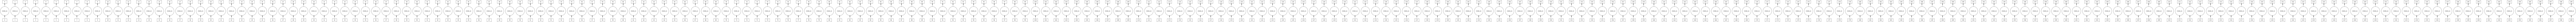

In [21]:
start = time()
rotated = db.map(rotate_ev, data_db)
stop = time()

print('Execution time:', stop-start)

rotated.visualize()

#### Plot the rotated event

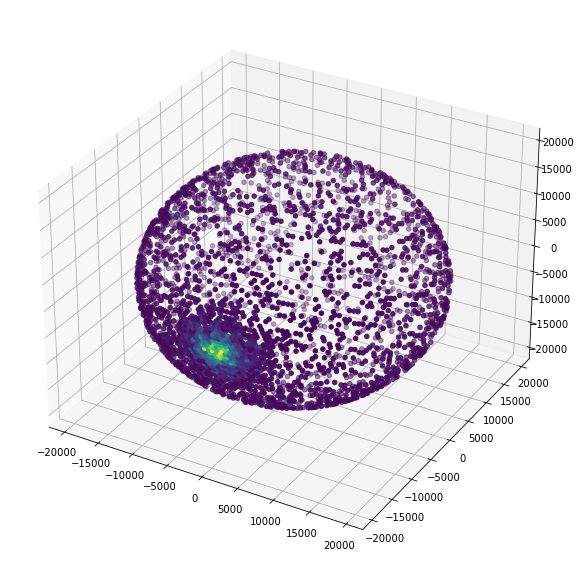

In [22]:
ev = 4
rot = rotated.take(ev+1)[ev]

fig = plt.figure(figsize=(10,12))
axr = fig.add_subplot(111, projection='3d')

axr.scatter(
    xs = rot[1, :],
    ys = -rot[0, :],
    zs = rot[2, :],
    c  = rot[4, :]
    )

## Distributed Processing - 2D mapping distributed by event

In [14]:
N_max = 115

def mapping_single_event(rotated_ev):
    ####################
    # rotated_ev must be computed
    ####################
    coord_new   = rotated_ev[:3]
    charge_hitt = rotated_ev[4:, ].T
    R           = rotated_ev[3, ].mean()

    z_levels, step = np.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    #z_levels       = z_levels.persist()
    image_mat      = np.zeros((230,124,2))

    #masks = 

    for j, z in enumerate(z_levels):
        mask = (np.abs(coord_new[2,] - z) < step)         #(np.abs(pmt_pos.z - z) < delta)
        if(not np.any(mask)): continue
        masked = coord_new[:,mask]


        Rz = (R**2 - z**2)
        Neff = 0 if Rz < 0 else N_max * np.sqrt(Rz) / R
        #ix = np.zeros(np.sum(mask), dtype=np.int32)
        ix = np.around( Neff * (np.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)
        #ix = ix.compute()
        if(np.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230

        image_mat[ix, j,] = charge_hitt[mask, ]

                # if np.isnan(mat[ix, i+1]):
                #     mat[ix, i+1] = row.id
                # else:
                #     mat[ix, 123 if i else i] = row.id

    del rotated_ev
    return image_mat

Execution time: 0.0007166862487792969


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.406271 to fit


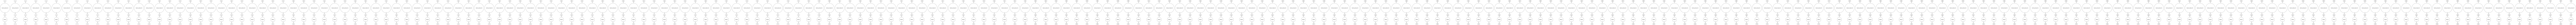

In [23]:
start = time()
mapped = db.map(mapping_single_event, rotated)
stop = time()

print('Execution time:', stop-start)
mapped.visualize()

In [24]:
start = time()
images = mapped.compute()
stop = time()

print('Execution time:', stop-start)

: 

: 

: 

In [17]:
len(images)

5000

### Plot mapped evemt

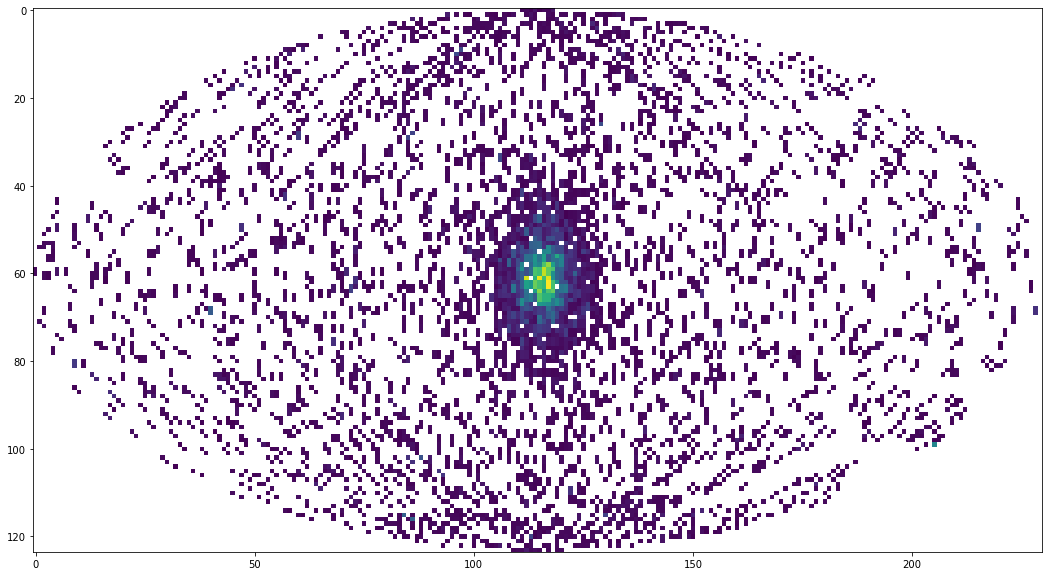

In [18]:
ev = 4

image = images[ev][:,:,0].T
image[image == 0] = np.NaN

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(image)
plt.show()

## Shutdown cluster

In [35]:
client.shutdown()